In [1]:
import ast
import json
import math
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from Bio import SeqIO

# Figure 2: Rates of adaptation in the receptor-binding proteins of viruses that are known to evolve anitgenically or be antigenically stable

Plot the estimated rate of adaptation in the receptor binding protein of viruses that have been experimentally-shown to evolve antigenically (H3N2, H1N1, Vic, Yam, 229E) and those that have been shown to be antigenically stable (measles, Flu C). Cite the references for experimental validation

In [2]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [45]:
def get_rate(virus_and_subtype):
    """
    Get rates of adaptation for the receptor-binding protein of each virus
    Return rates and 95CIs given in adaptive muts per codon per year x10-3
    """
    
    
    if 'dengue' in virus_and_subtype:
        virus = 'dengue'
        subtype = 'denv'+virus_and_subtype.split('dengue')[1]
        virus_and_subtype = 'dengue_'+subtype
    elif 'hepatitisA' in virus_and_subtype:
        virus = virus_and_subtype
        subtype=None
    else:
        if '_' in virus_and_subtype:
            virus = virus_and_subtype.split('_')[0]
            subtype = virus_and_subtype.split('_')[1]
        else:
            virus = virus_and_subtype
            subtype = None
    
    configs = readin_virus_config(virus)
    receptor_binding_gene = configs['receptor_binding']['virus_gene']
    if subtype:
        color = configs['color'][subtype]
    else:
        color=configs['color']
    

    bhatt_json_name = f'bhatt_results_nextstrain/{virus_and_subtype}_{receptor_binding_gene}_bhatt_analysis_bootstrapped.json'
    if path.exists(bhatt_json_name):
        with open(bhatt_json_name) as bhatt_handle:
            json_dict = json.load(bhatt_handle)
            (bhatt_window_midpoint, bhatt_adaptive_substitutions, 
             bhatt_adaptive_substitutions_per_codon, 
             bhatt_rate_of_adaptation, bhatt_bootstrap_adaptive_substitutions, 
             bhatt_bootstrap_adaptive_substitutions_per_codon, 
             bhatt_bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

        bs_slope_sci = [x * (10**3) for x in bhatt_bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)

    rb_rate = {virus_and_subtype: {'gene': receptor_binding_gene, 'color':color,
               'rate':bhatt_rate_of_adaptation* (10**3), 'upper_95ci':upper_95ci, 
                           'lower_95ci':lower_95ci}}
    
    return rb_rate
    

In [82]:
#make the virus name more legible
legible_titles_viruses = {'229e': 'Coronavirus 229E', 'h3n2': 'Influenza A/H3N2', 
                          'vic': 'Influenza B/Vic', 'yam': 'Influenza B/Yam', 
                          'h1n1pdm': 'Influenza A/H1N1pdm', 'influenzaC_Yamagata':'Influenza C/Yamagata', 
                          'measles': 'Measles'
                         }

In [263]:
#citations for experimental validation
#229e: (https://doi.org/10.1371/journal.ppat.1009453)
#fluC: (https://doi.org/10.1016/j.jcv.2014.06.017)
#measles: (https://doi.org/10.1128/JVI.03029-12), (https://doi.org/10.1016/j.xcrm.2021.100225)
#h3n2: (https://doi.org/110.1126/science.1097211)
#vic, yam, h1n1, h3n2: (https://doi.org/10.7554/eLife.01914)
#h1n1pdm, ferret model (not exactly what I want): (https://doi.org/10.1371/journal.ppat.1003354)
citations = {'229e': 'Eguia et al, 2021', 
                          'h3n2': 'Smith et al, 2004', 
                          'vic': 'Bedford et al, 2014', 
                          'yam': 'Bedford et al, 2014', 
                          'h1n1pdm': 'Bedford et al, 2014', 
                          'influenzaC_Yamagata':'Matsuzaki et al, 2014', 
                          'measles': 'Tahara et al, 2013;\nMuñoz-Alía et al, 2021'
                         }

In [26]:
antigenically_evolving = ['h3n2', 'h1n1pdm', 'vic', 'yam', '229e']
antigenically_stable = ['measles', 'influenzaC_Yamagata']

In [259]:
def compare_rates_between_known_viruses_flip(filename=False): 
    """
    Plot the estimated rate of adaptation in the receptor-binding protein for each virus 
    that is experimentally-validated. 
    """
    
    data_to_plot = {}
    
    for virus_and_subtype in antigenically_evolving:
        rb_rate = get_rate(virus_and_subtype)
        rb_rate[virus_and_subtype].update({'known':'antigenically_evolving'})
        data_to_plot.update(rb_rate)
        
    for virus_and_subtype in antigenically_stable:
        rb_rate = get_rate(virus_and_subtype)
        rb_rate[virus_and_subtype].update({'known':'antigenically_stable'})
        data_to_plot.update(rb_rate)

    
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 8
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['figure.dpi']= 300
    
    
    #initiate plot 
    fig, ax = plt.subplots(figsize=(6,4))
    
    
    #y coordinate counter
    ypos = 0
    #list of xtick labels
    y_labels = []
    y_ticks = []
    
    for virus, vdata in data_to_plot.items():
        rate = vdata['rate']
        
        ax.hlines(ypos, vdata['lower_95ci'], vdata['upper_95ci'], color=vdata['color'], linewidth=1.5)
        if vdata['known'] == 'antigenically_evolving':
            ax.plot(rate, ypos, 'o', ms=12, color='white', 
                       markeredgewidth=1.5, markeredgecolor=vdata['color'])
        else:
            ax.plot(rate, ypos, 'o', ms=12, color=vdata['color'], 
                       markeredgewidth=1.5, markeredgecolor=vdata['color'])
        #label the rate of adaptation next to virus
        ax.text(rate+0.22, ypos-0.25,
                       f'rate = {round(rate,2):.2f}', fontsize=8,
                       color=vdata['color'])
        
        #keep track of name and X coordinate of virus
        y_ticks.append(ypos)
        gene = vdata['gene'].upper()
        y_labels.append(f'{legible_titles_viruses[virus]}\n{gene}')
        #annotate with citations
        ax.text(5.4, ypos, citations[virus], fontsize=6, va='center', color='black')
        
        #increase xpos for next virus
        ypos+=1
        
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels) 
    
    #title for citation column
    ax.text(5.4, 6.4, 'Experimental\nValidation:', fontsize=8, weight='bold')
    
    #vertical line at y=1 dividing the viruses that evolve antigenically and those that don't
    ax.axvline(1.0, color='#d3d3d3', linestyle='dashed', zorder=1)
    
    #add legend
    handles = [Line2D([], [], color="white", marker='o', markerfacecolor="#808080", markersize=10, 
                      markeredgewidth=1.5, markeredgecolor="#808080"),
               Line2D([], [], color="white", marker='o', markerfacecolor="white", markersize=10, 
                      markeredgewidth=1.5, markeredgecolor="#808080")]
    leg = ax.legend(handles, ['Antigenically Stable', 'Antigenically Evolving'],
                          bbox_to_anchor=(0.85, 1.1), frameon=True, labelspacing = 1.0, borderpad=0.75)
    #add border    
    leg.get_frame().set_edgecolor('#d3d3d3')
    
    
    #x-axis label
    ax.set_xlabel('Adaptive Muts per Codon per Year $(x 10^{-3})$\nin Receptor-Binding Protein')

        
    #remove box around plot
    sns.despine()
    
    fig.tight_layout()
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')


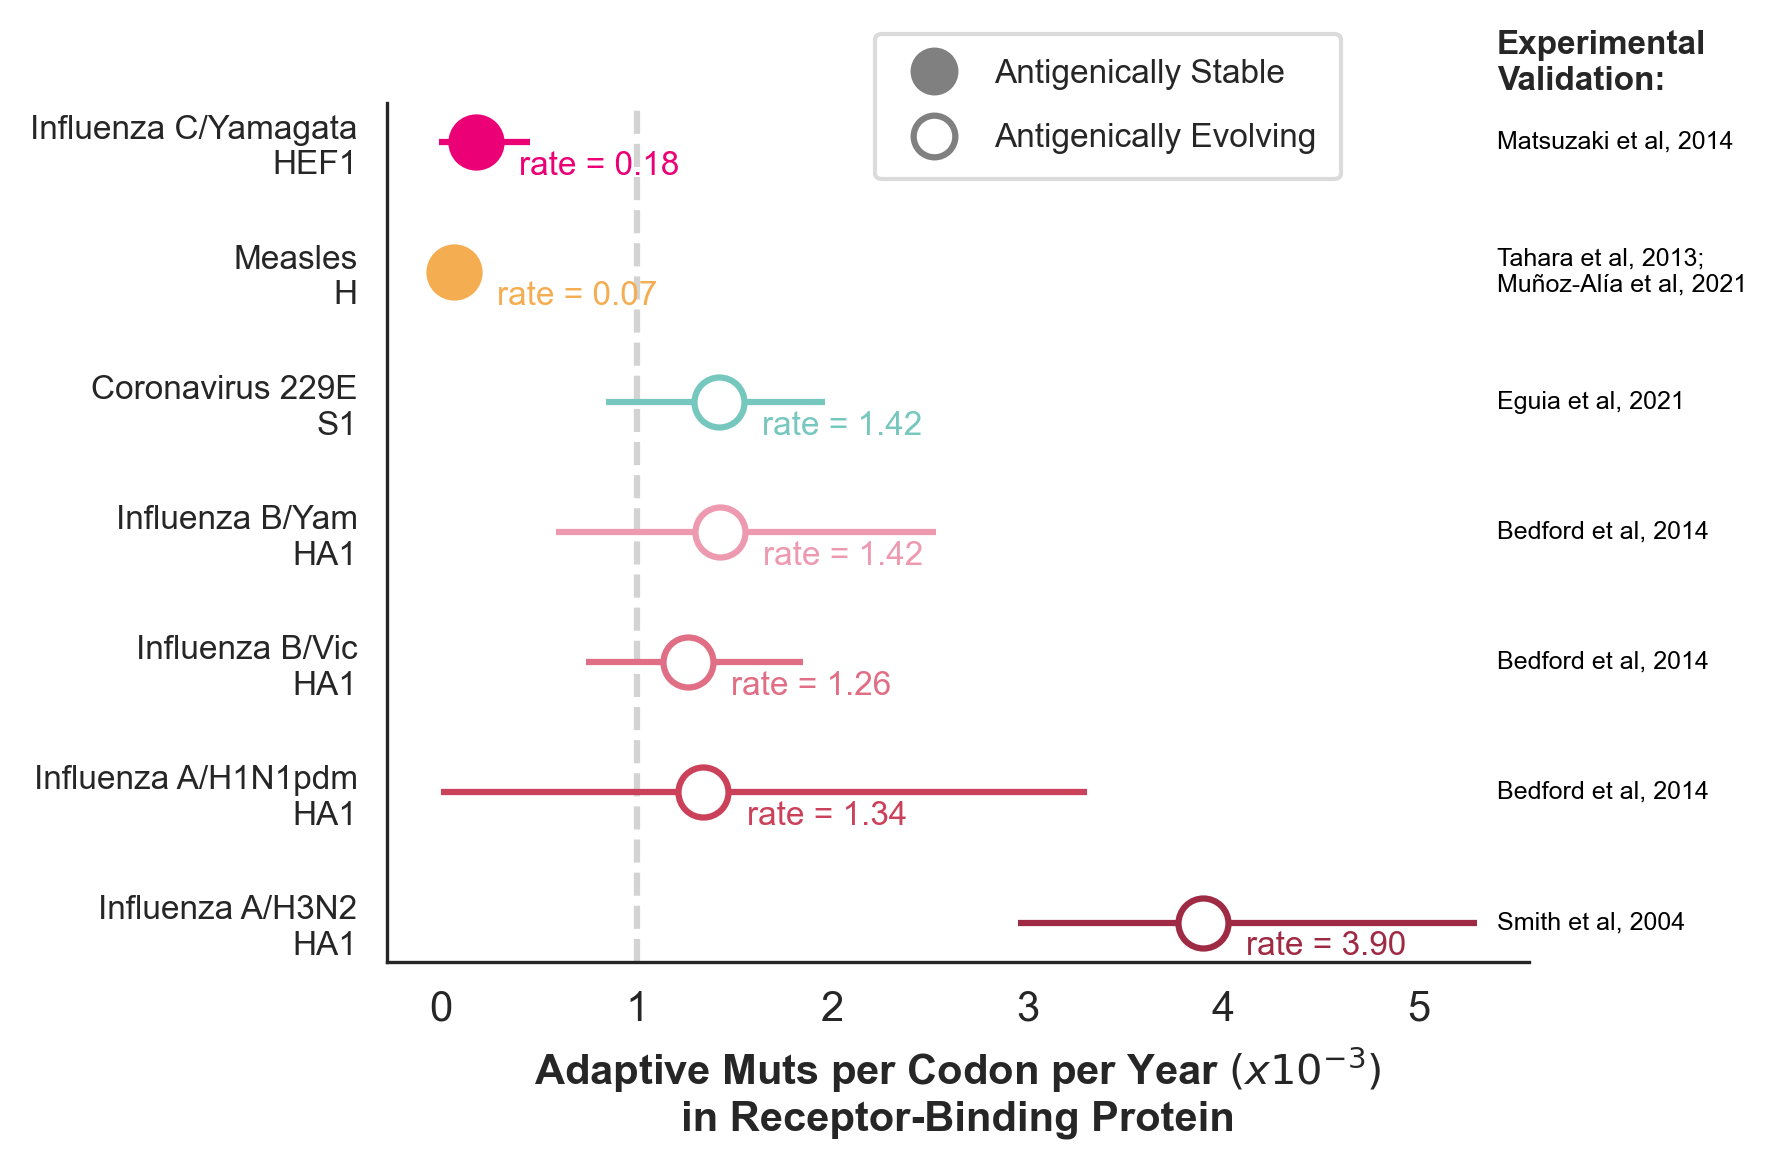

In [266]:
compare_rates_between_known_viruses_flip(filename='manuscript_figures/Figure2.png')

In [190]:
def compare_rates_between_known_viruses(filename=False): 
    """
    Plot the estimated rate of adaptation in the receptor-binding protein for each virus 
    that is experimentally-validated. 
    """
    
    data_to_plot = {}
    
    for virus_and_subtype in antigenically_evolving:
        rb_rate = get_rate(virus_and_subtype)
        rb_rate[virus_and_subtype].update({'known':'antigenically_evolving'})
        data_to_plot.update(rb_rate)
        
    for virus_and_subtype in antigenically_stable:
        rb_rate = get_rate(virus_and_subtype)
        rb_rate[virus_and_subtype].update({'known':'antigenically_stable'})
        data_to_plot.update(rb_rate)

    
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['figure.dpi']= 300
    
    
    #initiate plot 
    fig, ax = plt.subplots(figsize=(6,4))
    
    
    #x coordinate counter
    xpos = 0
    #list of xtick labels
    x_labels = []
    x_ticks = []
    
    for virus, vdata in data_to_plot.items():
        rate = vdata['rate']
        
        ax.vlines(xpos, vdata['lower_95ci'], vdata['upper_95ci'], color=vdata['color'], linewidth=1.5)
        if vdata['known'] == 'antigenically_evolving':
            ax.plot(xpos, rate, 'o', ms=12, color='white', 
                       markeredgewidth=1.5, markeredgecolor=vdata['color'])
        else:
            ax.plot(xpos, rate, 'o', ms=12, color=vdata['color'], 
                       markeredgewidth=1.5, markeredgecolor=vdata['color'])
        #label the rate of adaptation next to virus
        ax.text(xpos+0.05, rate+0.3, 
                       f'rate=\n{round(rate,2):.2f}', fontsize=8,
                       color=vdata['color'])
        
        #keep track of name and X coordinate of virus
        x_ticks.append(xpos)
        gene = vdata['gene'].upper()
        x_labels.append(f'{legible_titles_viruses[virus]}\n{gene}')
        #increase xpos for next virus
        xpos+=1
        
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=90) 
    
    #horizontal line at y=1 dividing the viruses that evolve antigenically and those that don't
    ax.axhline(1.0, color='#d3d3d3', linestyle='dashed', zorder=1)
    
    #add legend
    handles = [Line2D([], [], color="white", marker='o', markerfacecolor="white", markersize=10, 
                      markeredgewidth=1.5, markeredgecolor="#808080"), 
               Line2D([], [], color="white", marker='o', markerfacecolor="#808080", markersize=10, 
                      markeredgewidth=1.5, markeredgecolor="#808080")]
    leg = ax.legend(handles, ['Antigenically Evolving', 'Antigenically Stable'],
                          bbox_to_anchor=(1.0, 1.0), frameon=True, labelspacing = 1.0, borderpad=0.75)
    #add border    
    leg.get_frame().set_edgecolor('#d3d3d3')
    
    
    #y-axis label
    ax.set_ylabel('Adaptive Muts per Codon per Year $(x 10^{-3})$\nin Receptor-Binding Protein')
    ax.yaxis.set_label_coords(-0.07, .4)
        
    #remove box around plot
    sns.despine()
    
    fig.tight_layout()
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')


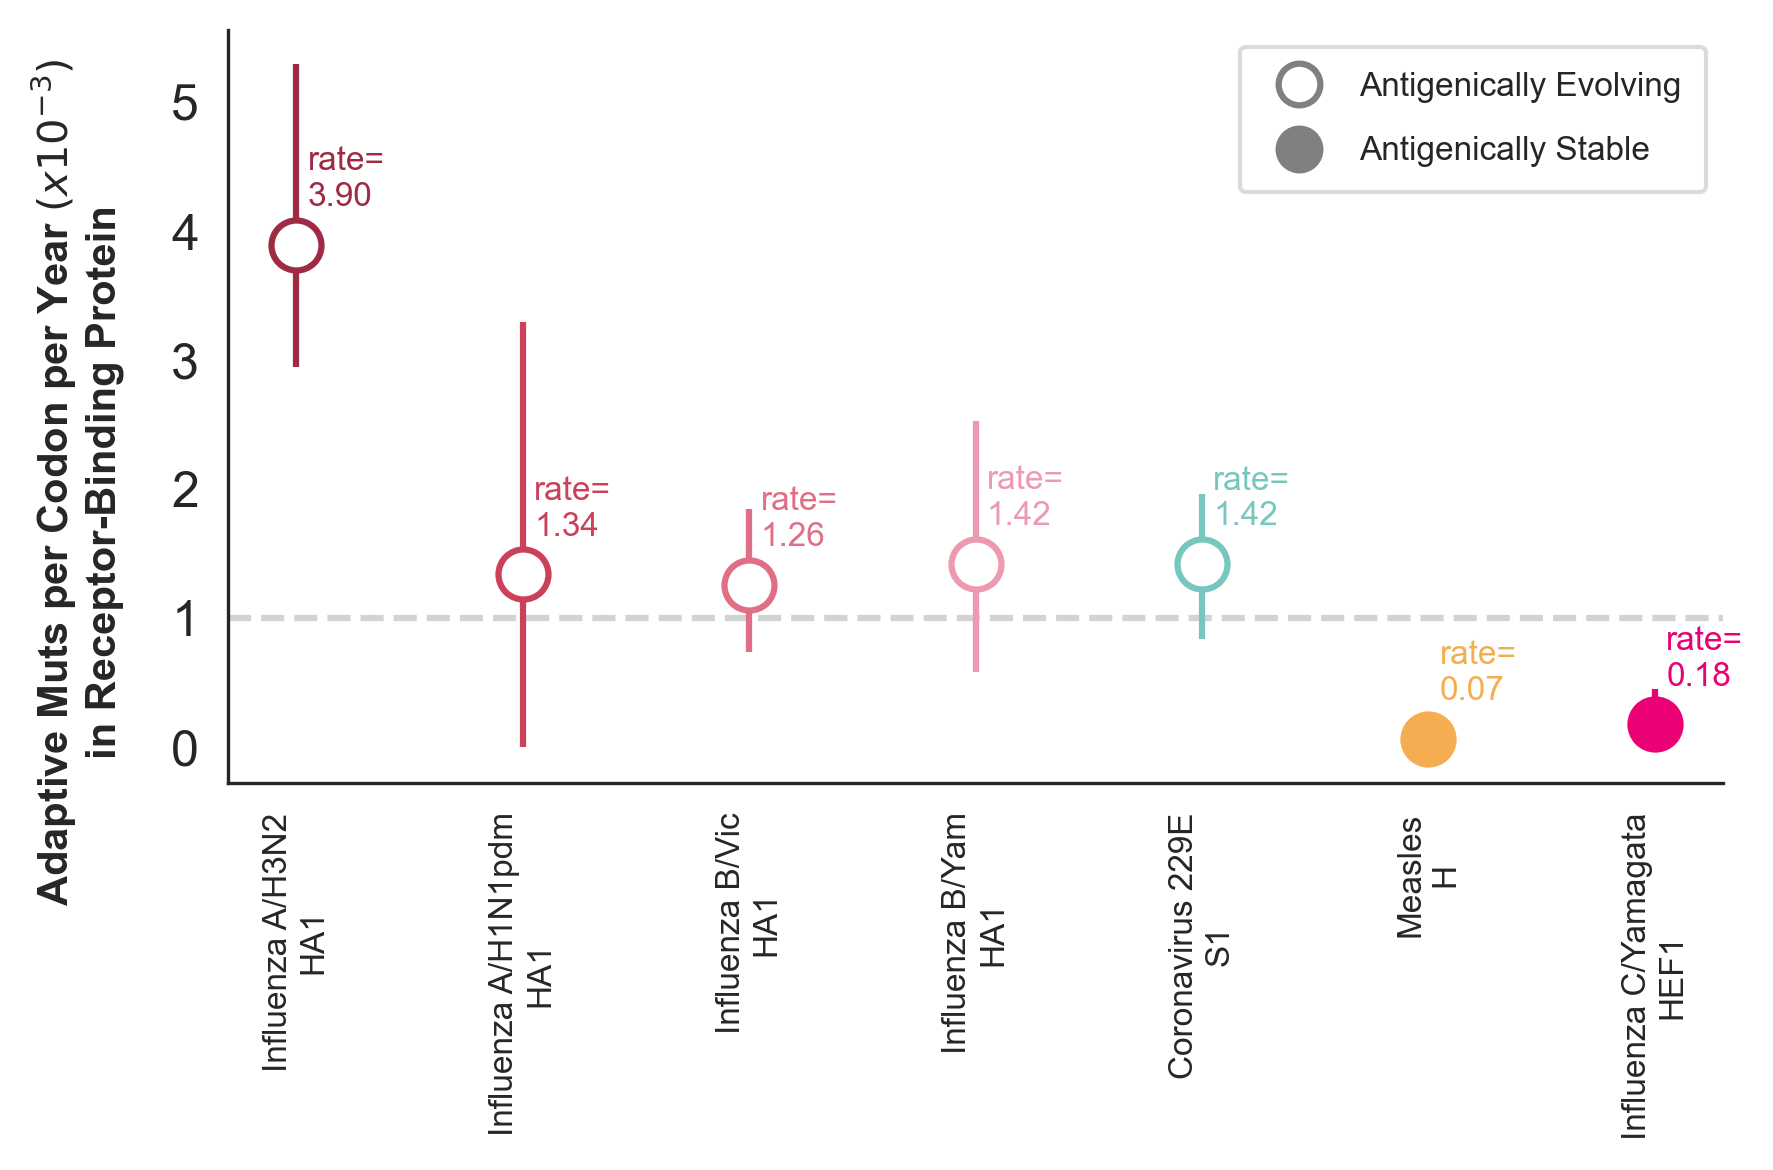

In [265]:
compare_rates_between_known_viruses()